# Qlearning, SARSA

#### Imports

In [1]:
from typing import Dict, List, Tuple, Optional
from collections import namedtuple
import os

In [2]:
from functional import seq, pseq
from functional.streams import Sequence
from IPython.core.display import HTML

def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

In [4]:
import functools
def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

# Qlearn

I found best parameters by interating over possible values of `learning rate`, `epsilon` and `discount factor`

In [6]:
%%sh 
tail -n 45 ../balance.py 


def find_best_params():

    float_range = np.arange(0.1, 1, step=0.1, dtype=float)
    decay_range = [1]  # np.arange(0.35, 1, step=0.05, dtype=float)

    def all():
        return range(3, 5)

    buckets = [
        # [x, v, ang, ang_v] for v in all() for x in all() for ang in all() for ang_v in all()
        [v, v, v, v] for v in all()
    ]

    def get_reward(params: Tuple[float, float, float, List[int], float]):
        lr, df, eps, buck, decay = params
        return QLearner(buck, eps, lr, df, False, True).learn(1000)

    # permutation_count = len(float_range) * len(float_range) * len(float_range) * len(buckets) * len(decay_range)
    # print(permutation_count, file=sys.stderr)
    # exit(1)

    print("params,iteration,reward")
    res = seq(tqdm(product(float_range, float_range, float_range, buckets, decay_range))).map(
        lambda params: (get_reward(params), params)).to_list()  # .order_by(lambda x: -x[0]).take(10).to_list()

    # # print("lp,lr,df,eps,buck")
    # 

## Plotting reward for best params

In [7]:
%%sh
ls *.csv 

1.csv
2.csv
3.csv
4.csv
5.csv
6.csv


In [5]:
trials= range(1,6 +1)
list(trials)

[1, 2, 3, 4, 5, 6]

In [13]:
def to_pandas(aggregate,trial:int):
    if type(aggregate) == list:
        aggregate = seq(aggregate)
    
    d = aggregate.to_pandas(columns= ['params','iteration','reward'])
    d['moving_avg'] = d.reward.rolling(window= 10).mean()
    d['trial'] = trial
    return d

In [14]:
def build_df(param:int) -> pd.DataFrame:
    
    builder = []
    
    for trial in trials:
        t = pd.read_csv(f"{trial}.csv") 
#         t['moving_avg'] = t.rolling(window=10).mean()
        
        res = seq(t).group_by(lambda x:x[0])\
        .map(lambda prams_df: to_pandas(prams_df[1],trial).dropna()).to_list()
        
        builder = builder + res
    
    return pd.concat(builder) 

In [15]:
df = build_df(trials)

In [28]:
def create_avgs(df_for_param:pd.DataFrame):
    
    df_for_param = df_for_param[['iteration', 'moving_avg']].groupby(['iteration'],as_index=False).agg(['mean','std']).reset_index()
    df_for_param['mean'] = df_for_param['moving_avg','mean']
    df_for_param['std'] = df_for_param['moving_avg','std']
    df_for_param = df_for_param.drop(columns= 'moving_avg')
    return df_for_param
    
#     to_plot = d.copy()
#     to_plot['minus_std'] = to_plot['mean'] - to_plot['std']
#     to_plot['plus_std'] = to_plot['mean'] + to_plot['std']
    

In [29]:
dfs = seq(df).group_by(lambda x: x[0]).map(lambda x: (x[0],create_avgs(seq(x[1]).to_pandas(columns=["params","iteration","reward","moving_avg","trial"]))))

In [36]:
maxes = dfs.filter(lambda x: x[1]['mean'].max() > 150)

In [50]:
def present(x:Tuple[str,pd.DataFrame]):
    to_plot = x[1].copy()
    to_plot['minus_std'] = to_plot['mean'] - to_plot['std']
    to_plot['plus_std'] = to_plot['mean'] + to_plot['std']
    
    to_plot = to_plot[['mean','plus_std','minus_std']]
#     display(HTML(x[0]))
    to_plot.plot(title= x[0])


0.2 0.1 0.7 4

0.2 0.1 0.7 4

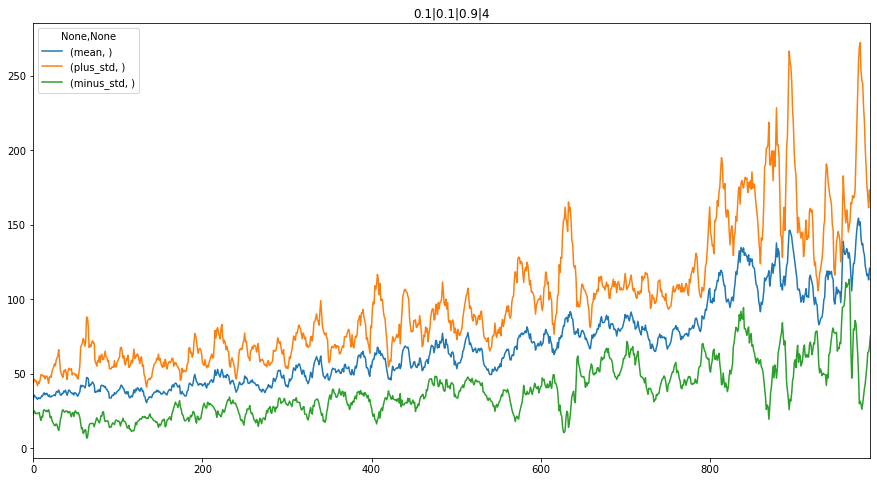

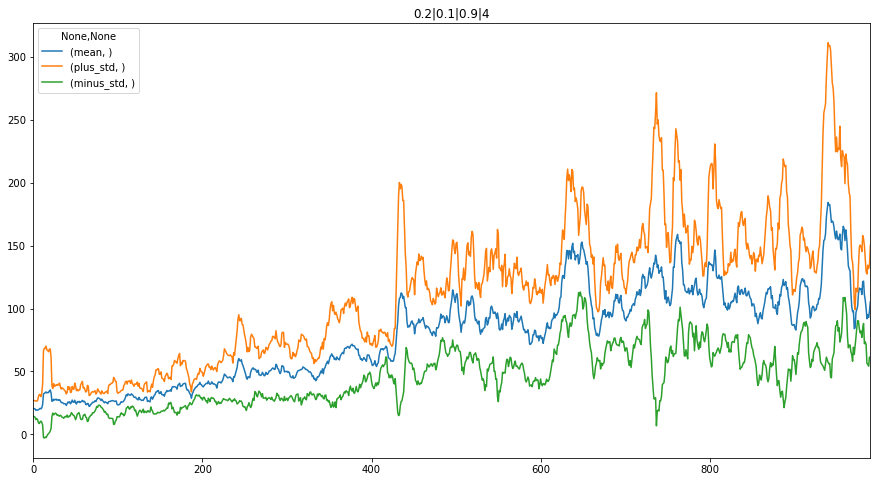

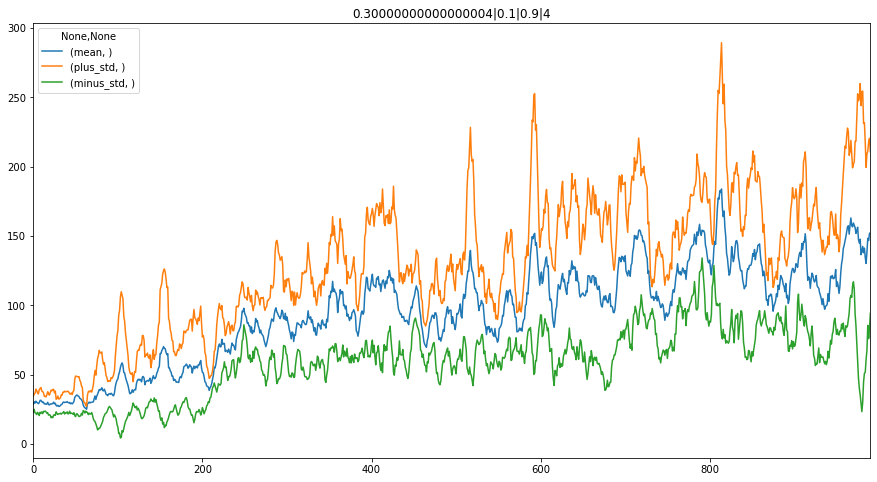

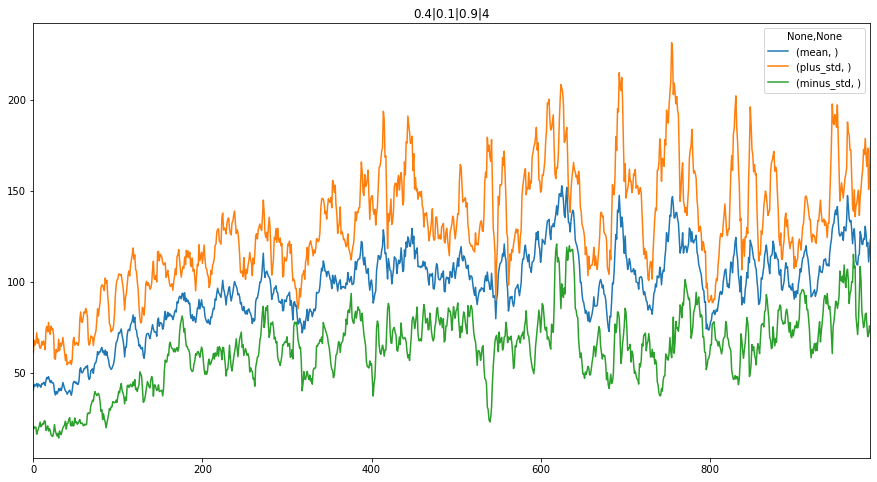

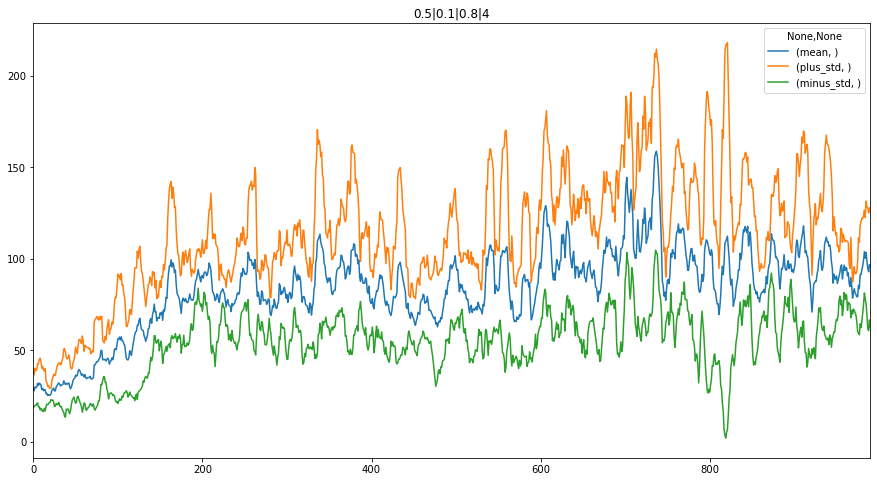

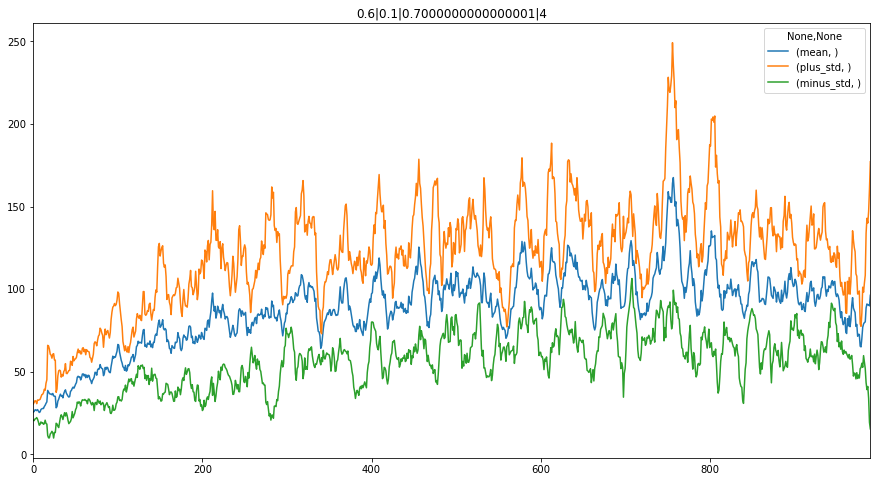

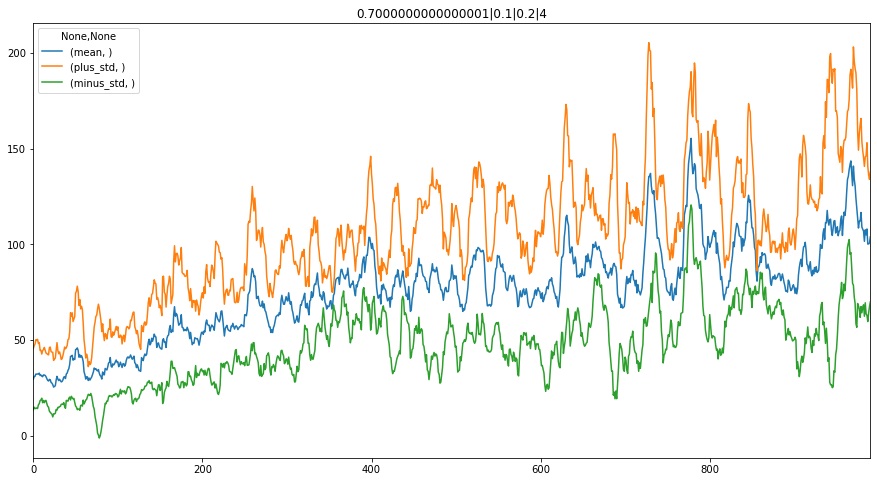

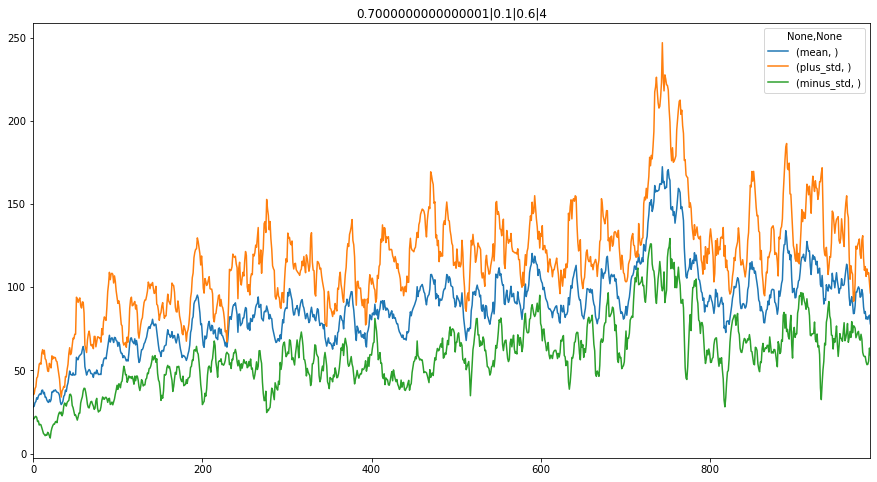

In [51]:
display(HTML("<h3>LearningRate | eps | discount_factor | buckets</h3>"))
maxes.for_each(present)